import functools
import manim
import numpy as np
import math

class SceneObjects:
    def __init__(self):
        vec = np.array([1,0])
        self.points = np.array([[4.2, 2.1], [1.2, -0.5], [3.7, 3.5], [-1.1, -0.2], [-1.9, 1.5]])
        self.points_projected = None
        self.update_vec(vec)
        self.dots = self.create_dots()
        
    def update_vec(self, vec):
        self.vec = vec
        self.points_projected = self.project(self.points, self.vec)
    
    @staticmethod
    def project(points, vec):
        scalars = points @ vec.T
        projected_points = scalars[:, np.newaxis] @ vec.T[np.newaxis, :]
        return projected_points
        
    def create_dots(self):
        dots = []
        def reproject_dot(o, i):
            o.move_to([*self.points_projected[i], 0])
        for i,p in enumerate(self.points_projected):
            d = manim.Dot([*p, 0])
            d.add_updater(functools.partial(reproject_dot, i=i))
            dots.append(d)            
        return dots
    
    
class MyScene(manim.Scene):
    def construct(self):
        self.add(manim.NumberPlane())
        scene_objects = SceneObjects()
        self.add(*scene_objects.dots)
        class ProxyAnim(manim.Animation):
            def update_mobjects(self, dt):
                rotate_rate = 0.2
                rotate_rads = dt * rotate_rate
                v_new = scene_objects.vec @ np.array([[math.cos(rotate_rads), math.sin(rotate_rads)],
                                                      [-math.sin(rotate_rads), math.cos(rotate_rads)]])
                scene_objects.update_vec(v_new)
        self.play(ProxyAnim(None))
        self.wait()
            

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import manim
import functools
import copy

Ref  
[Colors](https://www.reddit.com/r/manim/comments/dzxoen/predefined_color_scheme/)

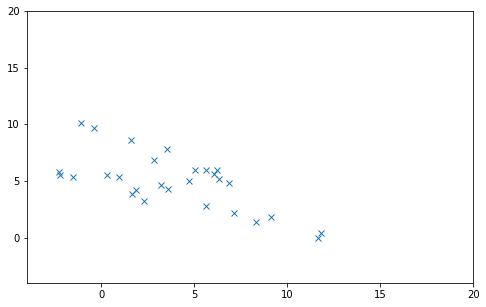

In [2]:
NUM_POINTS_PER_CLASS = 14
NUM_CLASSES = 2
NUM_POINTS = NUM_CLASSES * NUM_POINTS_PER_CLASS

def generate_data():
    seed = 124
    rng = np.random.Generator(np.random.PCG64(seed))
    def transform(points, rotate_rads, offset):
        scale = np.array([[0.5, 0], [0, 5.0]])
        rotate = np.array([[math.cos(rotate_rads), math.sin(rotate_rads)],
                           [-math.sin(rotate_rads), math.cos(rotate_rads)]])
        points = points @ scale
        points = points @ rotate
        points = points + offset
        return points
    points = rng.multivariate_normal([0,0], [[1, 0],[0,1]], size=NUM_POINTS)
    points_c1 = transform(points[:NUM_POINTS//2], 1.2, np.array([3, 4]))
    points_c2 = transform(points[NUM_POINTS//2:], 0.9, np.array([5, 6]))
    return np.concatenate([points_c1, points_c2], axis=0)

points = generate_data()
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim([-4, 20])
ax.set_xlim([-4, 20])
points.T[0, :]
ax.plot(points.T[0, :], points.T[1, :], 'x')

In [21]:
def project_points(points, vec, progress):
    scalars = points @ vec.T
    projected_points = scalars[:, np.newaxis] @ vec.T[np.newaxis, :]
    interpolated = points - progress * (points - projected_points) 
    return projected_points, interpolated

def vec_to_angle(vec):
    a = np.arctan2(vec[1], vec[0])
    if a < 0:
        a = 2*math.pi + a
    return a

class SceneData:
    def __init__(self, points, vec, progress=0):
        self.points = points
        self.points_projected = None
        self.points_progress = None
        self.vec = vec
        self.progress = progress
        self.update()
        
    def update(self):
        projected, progress =  project_points(self.points, self.vec, self.progress)
        self.points_projected = projected
        self.points_progress = progress
        
    def update_vec(self, vec):
        self.vec = vec
        self.update()
    
    def update_progress(self, progress):
        self.progress = progress
        self.update()
        
        
class SceneObjects:
    def __init__(self, scene_data):
        self.scene_data = scene_data
        self.dots = self.create_dots(scene_data)
        self.dots_projected = self.create_projected_dots(scene_data)
        self.projection_lines = self.create_projection_lines(scene_data)
        self.vec_arrow = self.create_vec_arrow(scene_data)
        self.vec_line = self.create_vec_line(scene_data)
    
    @staticmethod
    def create_dots(scene_data):
        dots = SceneObjects.create_stationary_dots(scene_data)
        for i,d in enumerate(dots):
            def update_dot(i, o):
                o.move_to([*scene_data.points_progress[i], 0])
            d.add_updater(functools.partial(update_dot, i))
        return dots
   
    @staticmethod
    def create_stationary_dots(scene_data):
        dots = []
        for i,p in enumerate(scene_data.points_progress):
            d = manim.Dot([*p, 0])
            dots.append(d)
        return dots

    @staticmethod
    def create_projected_dots(scene_data):
        dots = []
        color = manim.utils.color.YELLOW
        for i,p in enumerate(scene_data.points_projected):
            d = manim.Dot([*p, 0], color=color)
            def reproject_dot(i, o):
                o.move_to([*scene_data.points_projected[i], 0])
            d.add_updater(functools.partial(reproject_dot, i))
            dots.append(d)
        return dots
    
    @staticmethod
    def create_projection_lines(scene_data):
        lines = []
        if scene_data.points.shape != scene_data.points_projected.shape:
            raise Exception('Points and projections must come in pairs.')
        for i, (p1, p2) in enumerate(zip(scene_data.points_progress, scene_data.points_projected)):
            l = manim.DashedLine([*p1, 0], [*p2, 0], 
                          dash_length=0.2, 
                          positive_space_ratio=0.8,
                          color='#707070')
            def reproject(i, o):
                # Because I want the dashes to increase/decrease and not stretch/shrink, I'm using
                # a replace instead of an update.
                # o.put_start_and_end_on([*scene_data.points[i],0], [*scene_data.points_projected[i], 0])
                l2 = manim.DashedLine([*scene_data.points_progress[i], 0], [*scene_data.points_projected[i], 0], 
                              dash_length=0.2, 
                              positive_space_ratio=0.8,
                              color='#707070')
                o.become(l2)
            l.add_updater(functools.partial(reproject, i))
            lines.append(l)
        return lines
    
    @staticmethod
    def create_vec_arrow(scene_data):
        vec = manim.Arrow(manim.ORIGIN, [*scene_data.vec, 0], buff=0)
        def rotate_vec(o):
            o.set_angle(vec_to_angle(scene_data.vec))
        vec.add_updater(rotate_vec)
        return vec
    
    @staticmethod
    def create_vec_line(scene_data):
        color = manim.utils.color.YELLOW_A
        stroke_width = 6.0
        line = manim.NumberLine(rotation=math.atan(scene_data.vec[1]/scene_data.vec[0]),
                                length=40, 
                                include_numbers=True,
                                stroke_width=stroke_width, color=color)
        def rotate_line(o):
            o.rotate_about_zero(vec_to_angle(scene_data.vec) - line.get_angle())
        line.add_updater(rotate_line)
        return line
    
        
def create_data(starting_vec=None):
    if starting_vec is None:
        starting_vec = np.array([math.cos(0), math.sin(0)])
    points = generate_data()
    sd = SceneData(points, starting_vec)
    so = SceneObjects(sd)
    return sd, so

In [22]:
def setup_camera(scene):
    scene.camera.frame_center = np.array([5, 2, 0])
    scene.camera.frame.scale(2.3)
    
def setup_plane(scene):
    plane = manim.NumberPlane(x_range=[-30, 30], y_range=[-30, 30])
    scene.add(plane)

def setup_scene(scene):
    setup_camera(scene)
    setup_plane(scene)

In [23]:
class MasterAnim(manim.Animation):
    def update_mobjects(self, dt):
        v = sd.vec
        dt = dt * 0.25
        v_new = v @ np.array([[math.cos(dt), math.sin(dt)],[-math.sin(dt), math.cos(dt)]])
        sd.update_vec(v_new)
        
class ProjectionAnim(manim.Animation):
    def interpolate_mobject(self, alpha):
        sd.update_progress(alpha)

class DisplayProjected(manim.MovingCameraScene):
    def construct(self):
        sd, so = create_data()
        setup_scene(self)
        self.add(*so.projection_lines)
        self.add(*so.dots)
        self.add(*so.dots_projected)
        self.add(*so.vec_arrow)
        self.add(*so.vec_line)
        #self.play(MasterAnim(None))
        self.play(ProjectionAnim(None, rate_func=manim.rate_functions.ease_out_sine))
        self.wait()

In [38]:
class ProjectionAnim(manim.Animation):
    def __init__(self, scene_data, **kwargs):
        self.scene_data = scene_data
        super().__init__(None, **kwargs)
        
    def interpolate_mobject(self, alpha):
        self.scene_data.update_progress(alpha)

class ProjectAndFadeAnim(manim.AnimationGroup):
    def __init__(self, scene_data, **kwargs):
        orig_dots = SceneObjects.create_stationary_dots(scene_data)
        g = manim.Group()
        for d in orig_dots:
            g.add(d.set_color(manim.utils.color.GREY))
        fade_out_dots = manim.FadeOut(g, rate_func=manim.rate_functions.ease_out_sine)
        super().__init__(fade_out_dots, ProjectionAnim(scene_data), **kwargs)

# Story

Quite a lot of machine learning techniques can be viewed as an attempt to find a vector to represent some data. Usually, we use this vector to project the data onto a line; this is converting each data point into a single number.

From a high level perspective, we have available high-dimensional data points and we wish to convert each data point to a single number, and once we do, we can design simple rules, like `if x > 0, then class_1 else class_2`. 

Perceptrons, regression, support vector machines, and principal component analysis are examples of methods which can be viewed as searching for an appropriate vector, then projecting all data onto this vector. A single visualization can provide visual intuition for all of these methods.

You can find yourself reinventing famous machine learning methods if you give yourself a problem with the right constraints. Consider you are given the following data points. There are 14 data points in 2D Euclidean space. 

In [52]:
class DisplayPoints(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data()
        self.add(*so.dots)

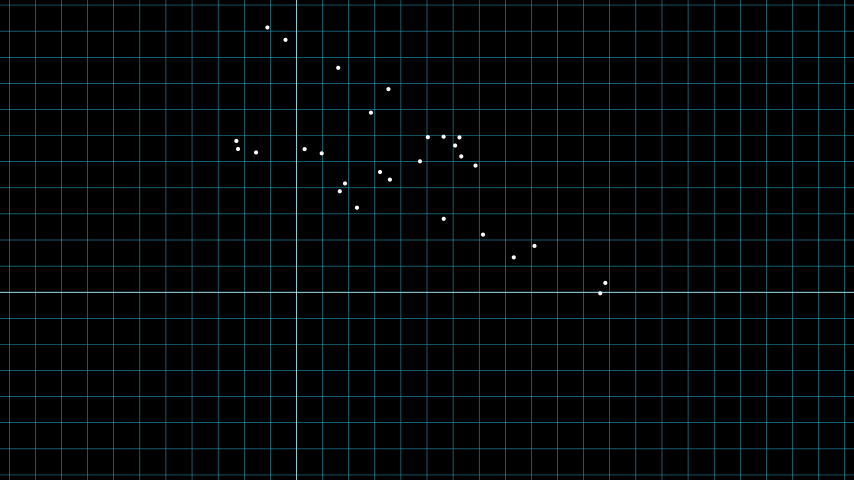

In [51]:
%%manim -ql -v warning -o points.png DisplayPoints
pass

Warm up with a simple projection: the data can be projected onto the first axis by zero-ing the second element of each data point.

In [49]:
class DisplayProjectedX(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data()
        self.add(*so.projection_lines)
        self.add(*so.dots)
        #self.add(*so.dots_projected)
        #self.add(*so.vec_line)
        self.play(ProjectAndFadeAnim(sd))
        self.wait()

In [50]:
%%manim -ql -v warning -o project-to-x.mp4 DisplayProjectedX
pass

And the data can be projected onto the the second axis by zero-ing the first element of each data point.

In [41]:
class DisplayProjectedY(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data(starting_vec=np.array([0, 1]))
        self.add(*so.projection_lines)
        self.add(*so.dots)
        #self.add(*so.dots_projected)
        #self.add(*so.vec_line)
        self.play(ProjectAndFadeAnim(sd))
        self.wait()

In [45]:
%%manim -ql -v warning DisplayProjectedY
pass

<ipython-input-21-185a95dbcb24>:109: RuntimeWarning: divide by zero encountered in long_scalars
  line = manim.NumberLine(rotation=math.atan(scene_data.vec[1]/scene_data.vec[0]),


Below you can see all possible projections of the data onto a vector of unit length.

In [67]:
class RotateVectorAnim(manim.Animation):
    def __init__(self, scene_data, **kwargs):
        self.scene_data = scene_data
        super().__init__(None, run_time=8, rate_func=manim.rate_functions.linear, **kwargs)
        
    def update_mobjects(self, dt):
        v = self.scene_data.vec
        step = (dt * math.pi * 2)/self.run_time
        v_new = v @ np.array([[math.cos(step), math.sin(step)],
                              [-math.sin(step), math.cos(step)]])
        self.scene_data.update_vec(v_new) 
        
class AllUnitProjections(manim.MovingCameraScene):
    def construct(self):
        setup_scene(self)
        sd, so = create_data()
        self.add(*so.dots)
        self.add(*so.projection_lines)
        self.add(*so.dots_projected)
        self.add(*so.vec_arrow)
        self.add(*so.vec_line)
        self.play(RotateVectorAnim(sd))

In [ ]:
%%manim -qh -v warning -o all-unit-projections.mp4 AllUnitProjections
pass

Animation 0: RotateVectorAnim(Mobject):  28%|██▊       | 133/480 [01:35<04:37,  1.25it/s]